In [1]:
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"
import sys
from utils.tools import load_obj, save_obj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

In [2]:
def iewt1d(ewt, mfb):
    # 转化为原始信号
    real = all(np.isreal(ewt[0]))
    if real:
        rec = np.zeros(len(ewt[0]))
        for i in range(0,len(ewt)):
            rec += np.real(np.fft.ifft(np.fft.fft(ewt[i])*mfb[i]))
    else:
        rec = np.zeros(len(ewt[0]))*0j
        for i in range(0,len(ewt)):
            rec += np.fft.ifft(np.fft.fft(ewt[i])*mfb[i])
    return rec

In [3]:
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))
def metircs(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    mape = MAPE(pred, true)
    return {"rmse":rmse, "r2":r2, "mape":mape}

## 数据加载

In [5]:
TARGET = "assigned memory usage"
cols = [TARGET]
N = 3

df = pd.read_csv(f"./data/{TARGET}.csv", index_col=[0])
df.head()
metrics_dict = {}

,assigned memory usage,assigned memory usage0,assigned memory usage1,assigned memory usage2,assigned memory usage0_mfb,assigned memory usage1_mfb,assigned memory usage2_mfb
start time,,,,,,,
600000000,3415.579234,3568.505772,4.114919,-164.808972,1.000000,0.000000,0.000000
900000000,3423.313001,3568.403518,4.301215,-155.535047,1.000000,0.000000,0.000000
1200000000,3401.148691,3568.301218,4.487628,-179.572056,0.707107,0.707107,0.000000
1500000000,3447.942116,3568.198872,4.674157,-130.663498,0.000000,0.999952,0.009787
1800000000,3402.758848,3568.096479,4.860799,-178.166113,0.000000,0.707107,0.707107


## lstm-ewt 预测

In [29]:
seq_len, pred_len = 80, 1
total_len = len(df)
model_name = "lstmewt"

In [31]:
# 不同horizon下的分量预测结果
lstmewt_horizon_dict = {}
for hn in range(1, 21):
    # 加载不同horizon下的各分量预测结果
    pred_lst = []
    # true_lst = []
    for i in range(N):
        true, pred = load_obj(f"./results/google1/lstm_google1_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}{i}_0/true_pred.pkl")
        # true_lst.append(true)
        pred_lst.append(pred)
    pred_lstm = np.concatenate(pred_lst,axis=-1)
    # true_lstm = np.concatenate(true_lst, axis=-1)
    lstmewt_horizon_dict[hn] = pred_lstm

In [32]:
target_horizon = 1
lstmewt_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values
        # seq_len部分的ewt
        pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
        # 和预测得到的ewt组合
        pred_horizon = lstmewt_horizon_dict[horizon][:,0,:]
        # pred_horizon = pred_lstm[:,target_horizon-1,:]]
        ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
        # 重构
        reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
        target = df[col]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = reconstruction[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test)
        
        lstmewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        lstmewt_target_horizon_data = [target, reconstruction, ewt_pred]
trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
lstmewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["lstmewt"] = pd.DataFrame(lstmewt_metrics).T

In [33]:
metrics_dict["lstmewt"]

,rmse,r2,mape
horizon1,60.172101,0.848334,0.011401
horizon2,79.661876,0.734173,0.015650
horizon3,93.957334,0.630206,0.018983
horizon4,105.435908,0.534396,0.021458
horizon5,113.561964,0.459861,0.023271
horizon6,123.311923,0.363131,0.025781
horizon7,127.165295,0.322706,0.026570
horizon8,129.051898,0.302460,0.027312
horizon9,129.678266,0.295573,0.027413
horizon10,130.622172,0.285280,0.027594


### target_horizon展示

In [34]:
target, reconstruction, ewt_pred = lstmewt_target_horizon_data
gap = target_horizon - 1

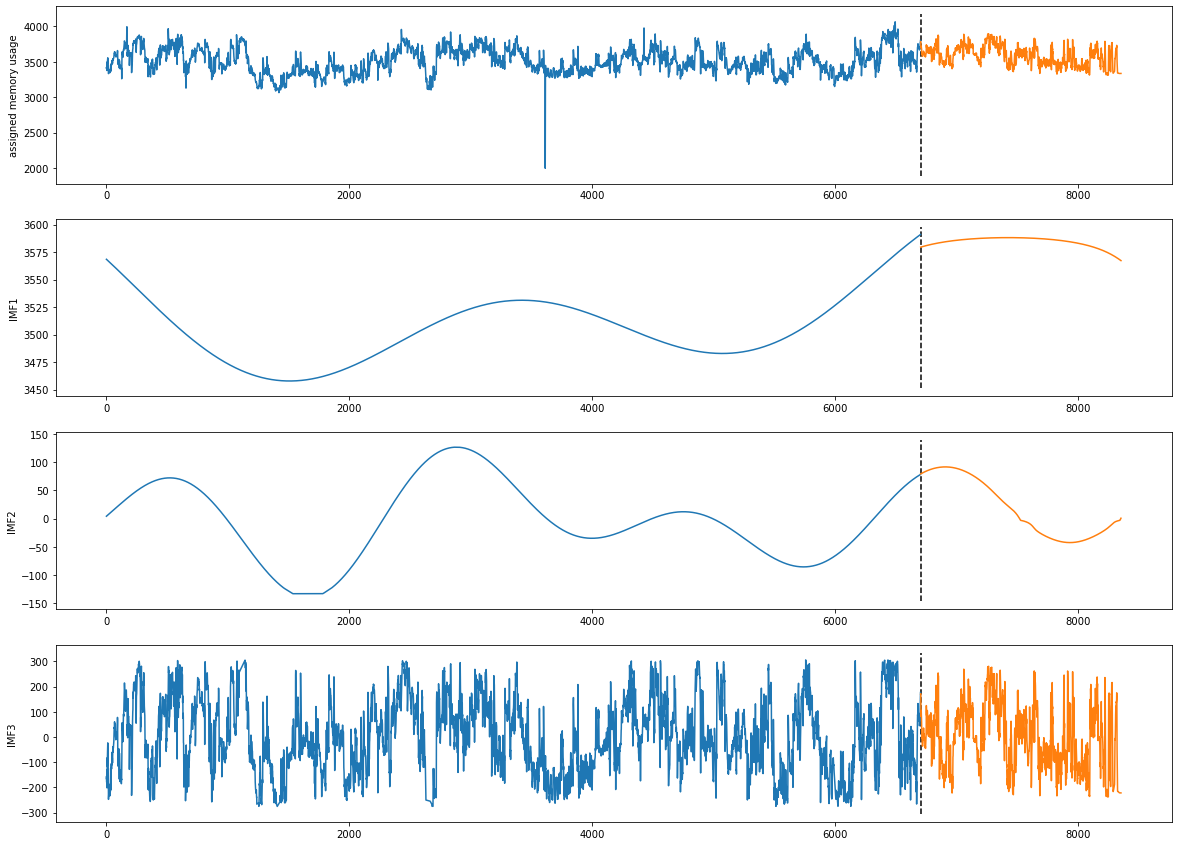

In [35]:
for col in cols:
    fig = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

In [36]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt0.png")

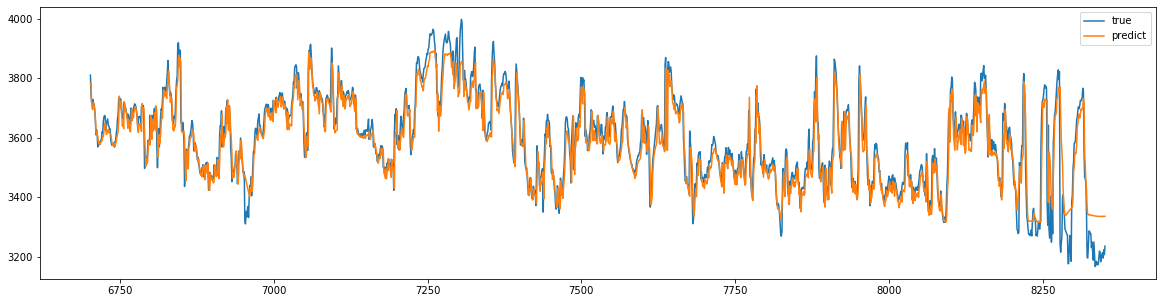

In [37]:
fig = plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:], label="predict")
plt.legend();

In [38]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt1.png")

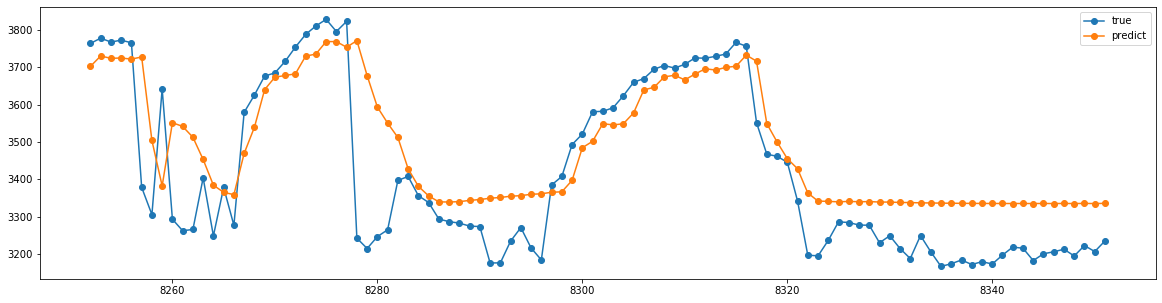

In [39]:
fig = plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-select_length, len(df)), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-select_length, len(df)), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

In [40]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt2.png")

## lstm 预测

In [41]:
seq_len, pred_len = 80, 1
total_len = len(df)

In [42]:
lstm_horizon_dict = {}
for hn in range(1, 21):
    true, pred = load_obj(f"./results/google1/lstm_google1_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}_0/true_pred.pkl")
    lstm_horizon_dict[hn] = pred

In [43]:
target_horizon = 1
lstm_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        # seq_len部分的col
        pre_col = df.iloc[:pre_len][[col]]
        # 和预测得到的col组合
        pred_horizon = lstm_horizon_dict[horizon][:,0,:]
        pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
        target = df[col]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = pred_horizon[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test.flatten())
        
        lstm_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        lstm_target_horizon_data = [target, pred_horizon]
    
trues_test_all, preds_test_all = np.concatenate(trues_test_lst), np.concatenate(preds_test_lst)
lstm_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["lstm"] = pd.DataFrame(lstm_metrics).T

In [44]:
metrics_dict["lstm"]

,rmse,r2,mape
horizon1,54.805333,0.874182,0.047380
horizon2,77.789987,0.746519,0.046649
horizon3,92.286000,0.643245,0.045216
horizon4,104.895692,0.539154,0.044931
horizon5,112.362564,0.471210,0.044141
horizon6,118.929758,0.407592,0.043730
horizon7,130.519404,0.286506,0.043752
horizon8,131.675914,0.273806,0.042748
horizon9,134.974936,0.236853,0.042107
horizon10,135.990005,0.225332,0.042258


## former-ewt 预测

In [6]:
seq_len, label_len, pred_len = 80, 10, 20
total_len = len(df)
target_horizon_data_dict = {}
target_horizon = 1

In [7]:
for model_name in ["auto", "in", "trans"]:
    # 读取数据
    ewt_pred_lst = []
    for i in range(N):
        true_, pred_ = load_obj(f"./results/google1/{model_name}former_google1_ftS_sl{seq_len}_ll{label_len}_pl{pred_len}_is1_os1_hn1_bs32_lr0.0001_{TARGET}{i}_0/true_pred.pkl")
        ewt_pred_lst.append(pred_)
    model_ewt_pred = np.concatenate(ewt_pred_lst,axis=-1)    
    
    ewt_metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, 21):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            # former多步预测时，截断了最后horizon个步长，为了对齐，要截断
            align_len = pred_len-horizon
            align_len = -total_len if align_len<=0 else align_len
            tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values[:-align_len]
            # seq_len部分的ewt
            pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
            # 和预测得到的ewt组合
            pred_horizon = model_ewt_pred[:,horizon-1,:]
            ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
            # 重构
            reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
            target = df[col][:-align_len]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = reconstruction[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test)

            ewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
        if horizon == target_horizon:
            ewt_target_horizon_data = [target, reconstruction, ewt_pred]
            target_horizon_data_dict[model_name+"ewt"] = ewt_target_horizon_data
            
    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    ewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
    metrics_dict[f"{model_name}ewt"] = pd.DataFrame(ewt_metrics).T

In [8]:
metrics_dict[f"{model_name}ewt"]

,rmse,r2,mape
horizon1,80.481518,0.708246,0.018054
horizon2,98.632595,0.563147,0.020898
horizon3,108.624289,0.472244,0.023043
horizon4,116.851734,0.392108,0.024524
horizon5,123.298338,0.326233,0.025984
horizon6,131.570008,0.236076,0.028280
horizon7,131.621348,0.238926,0.028371
horizon8,134.585319,0.207754,0.029123
horizon9,136.457357,0.189254,0.029604
horizon10,139.702917,0.153587,0.030227


### target_horizon展示

In [9]:
show_model = "auto"
target, reconstruction, ewt_pred = target_horizon_data_dict[show_model+"ewt"]
gap = target_horizon-1

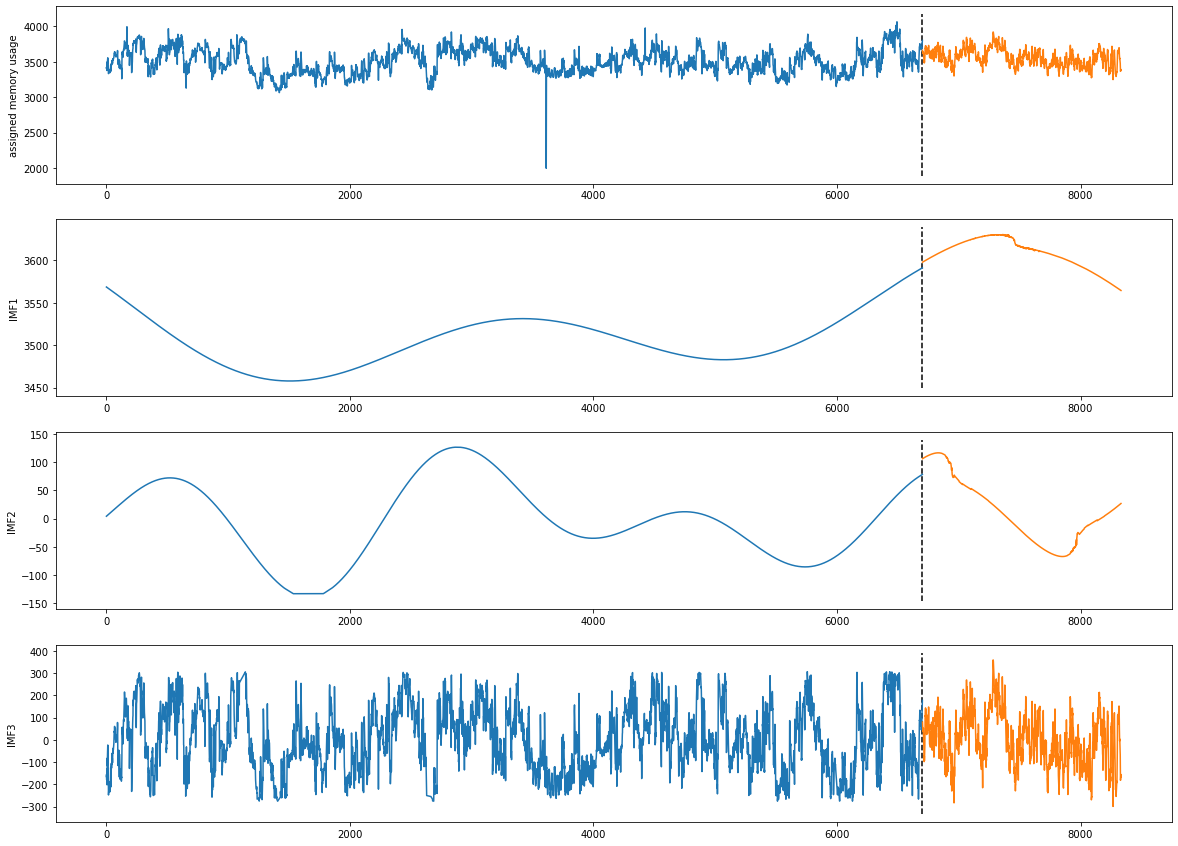

In [10]:
for col in cols:
    fig = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

In [11]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt0.png")

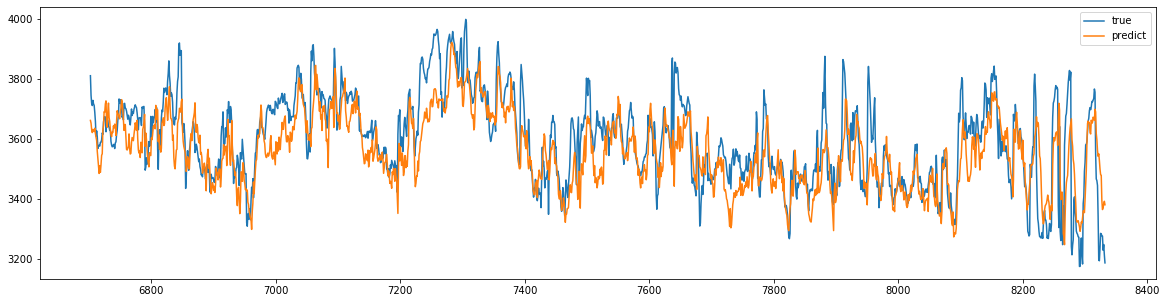

In [12]:
fig = plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:], label="predict")
plt.legend();

In [13]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt1.png")

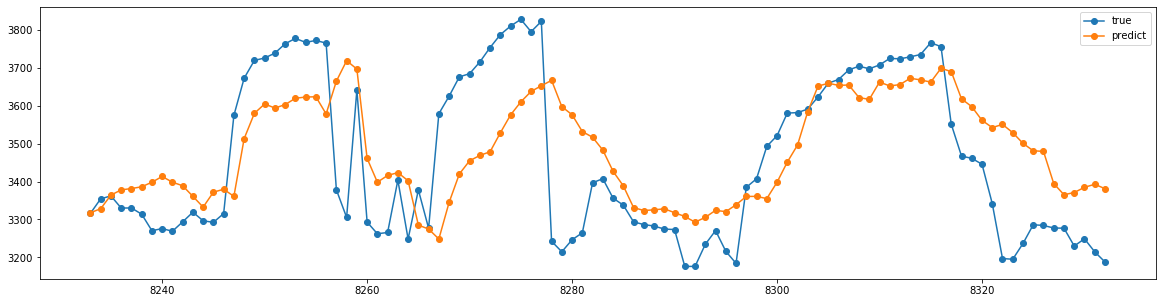

In [14]:
fig = plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

In [15]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt2.png")

## former预测

In [16]:
seq_len, label_len, pred_len = 80, 10, 20
total_len = len(df)
target_horizon = 1

In [17]:
for model_name in ["auto", "in", "trans"]:
    _true, _pred = load_obj(f"./results/google1/{model_name}former_google1_ftS_sl{seq_len}_ll{label_len}_pl{pred_len}_is1_os1_hn1_bs32_lr0.0001_{TARGET}_0/true_pred.pkl")

    _metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, 21):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            align_len = pred_len-horizon
            align_len = -total_len if align_len<=0 else align_len
            # seq_len部分的col
            pre_col = df.iloc[:pre_len][[col]]
            # 和预测得到的col组合
            pred_horizon = _pred[:,horizon-1,:]
            pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
            target = df[col][:-align_len]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = pred_horizon[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test.flatten())

            _metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
        if horizon == target_horizon:
            _target_horizon_data = [target, pred_horizon]

    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    _metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
    metrics_dict[f"{model_name}"] = pd.DataFrame(_metrics).T

In [18]:
metrics_dict[f"{model_name}"]

,rmse,r2,mape
horizon1,62.869195,0.821967,0.042764
horizon2,92.118382,0.618946,0.042911
horizon3,107.035390,0.487570,0.043315
horizon4,109.693330,0.464307,0.041878
horizon5,119.103589,0.371298,0.042554
horizon6,129.423566,0.260798,0.041788
horizon7,129.774880,0.260130,0.043005
horizon8,131.682974,0.241555,0.041979
horizon9,132.010315,0.241237,0.040829
horizon10,130.648283,0.259750,0.039420


## arima rolling

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARIMA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [20]:
def get_result(val_data, test_data, rolling=True, pred_len=20, seq_len=200):
    history = [x for x in val_data[-seq_len:, 0]]

    preds_lst = list()
    trues_lst = list()
    initial = True
    for t in tqdm(range(len(test_data[:, 0])-pred_len)):
        history = history[-seq_len:]
        if initial:
            model = ARMA(history, order=(5, 0, 0))
            try:
                model_fit = model.fit()
            except:
                model_fit = model.fit(start_params=model_fit.params)
                
            # 仅估计一次模型，否则，滚动预测，迭代feed数据，重新估计模型
            if not rolling:
                initial = False
            
        output = model_fit.forecast(pred_len)
        yhat = output[0]
        preds_lst.append(yhat)
        obs = test_data[:, 0][t]
        history.append(obs)
        trues_lst.append(test_data[:, 0][t:t+pred_len])
    return preds_lst, trues_lst

In [21]:
val_size = int(len(df)*0.1)
test_size = int(len(df)*0.2)
ar_data = df[cols].values
train_data, val_data, test_data \
    = ar_data[:(len(df)-test_size-val_size)], ar_data[(len(df)-test_size-val_size):(len(df)-test_size)], ar_data[-test_size:]

In [22]:
# arma_model=ARMA(train_data[:, 0], order=(5, 0, 0))
# arma_result=arma_model.fit()
# arma_result.summary()

In [23]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=True)

  0%|          | 0/1650 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [24]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, 21):
    ar_metrics[f"horizon{horizon}"] = metircs(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["allhorizon"] = metircs(ar_trues.flatten(), ar_preds.flatten())
metrics_dict["arima_rolling"] = pd.DataFrame(ar_metrics).T

In [25]:
metrics_dict["arima_rolling"]

,rmse,r2,mape
horizon1,51.423914,0.880391,0.008931
horizon2,74.282184,0.751462,0.014265
horizon3,88.241271,0.650347,0.017755
horizon4,99.642966,0.555908,0.020563
horizon5,110.029180,0.461021,0.023231
horizon6,117.418846,0.388958,0.025304
horizon7,123.907558,0.322465,0.027005
horizon8,128.917909,0.269869,0.028366
horizon9,132.478223,0.232367,0.029309
horizon10,135.297129,0.202983,0.030005


## arima static

In [26]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=False)

  0%|          | 0/1650 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [27]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, 21):
    ar_metrics[f"horizon{horizon}"] = metircs(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["allhorizon"] = metircs(ar_trues.flatten(), ar_preds.flatten())
metrics_dict["arima_static"] = pd.DataFrame(ar_metrics).T

In [28]:
metrics_dict["arima_static"]

,rmse,r2,mape
horizon1,200.591690,-0.819951,0.046459
horizon2,198.546343,-0.775612,0.045882
horizon3,196.675214,-0.736974,0.045365
horizon4,195.160118,-0.703576,0.044939
horizon5,193.728731,-0.670875,0.044537
horizon6,192.341751,-0.639618,0.044152
horizon7,191.030361,-0.610427,0.043793
horizon8,189.829889,-0.583081,0.043466
horizon9,188.702753,-0.557476,0.043163
horizon10,187.667142,-0.533441,0.042884


## 模型评估

In [45]:
def evaluation_show(taget_indictor, target_horizon, sort=True):
    hist_dict = {}
    for key, value in metrics_dict.items():
        hist_dict[key] = value[taget_indictor][target_horizon]
    if sort:
        hist_dict = dict(sorted(hist_dict.items(), key=lambda x:x[1]))
    fig = plt.figure(figsize=(10, 6))
    x, width = 0, 0.25
    xtick_lst = []
    xlabel_lst = []
    for key, value in hist_dict.items():
        xtick_lst.append(x)
        xlabel_lst.append(key)
        plt.bar(x, value, width=width, label=key)
        x += width
    plt.xticks(xtick_lst, xlabel_lst)
    plt.title(f"{taget_indictor}_{target_horizon}")
    plt.legend();
    return fig, hist_dict

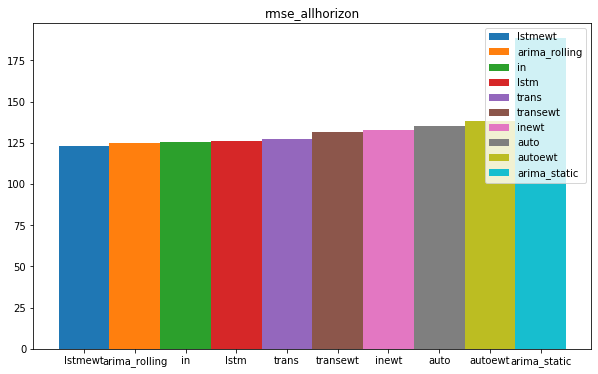

In [50]:
taget_indictor = 'rmse'
target_horizon = "allhorizon"
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

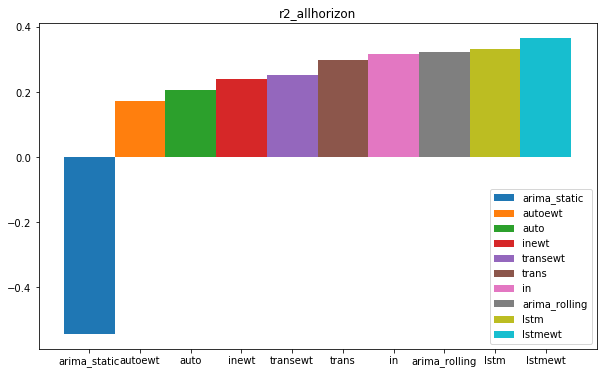

In [47]:
taget_indictor = 'r2'
target_horizon = "allhorizon"
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

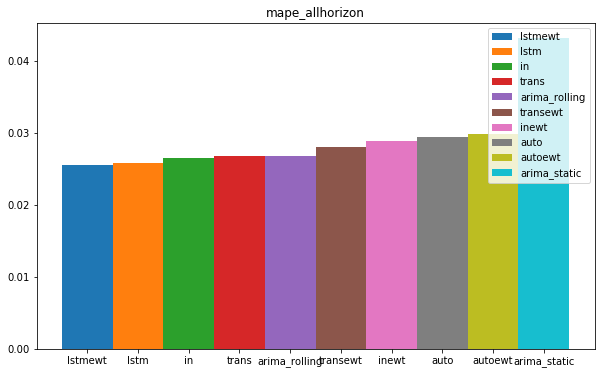

In [48]:
taget_indictor = 'mape'
target_horizon = "allhorizon"
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

### save_metrics

In [72]:
save_metrics = {}
for key, value in metrics_dict.items():
    save_metrics[key] = metrics_dict[key].loc[target_horizon, :].to_dict()

In [76]:
pd.DataFrame(save_metrics).T

,rmse,r2,mape
lstmewt,3.998587,-15.642492,0.100987
lstm,5.284120,-28.063679,0.136237
autoewt,2.425945,-5.161358,0.056339
inewt,4.497306,-20.174808,0.113447
transewt,4.085379,-16.473475,0.102741
auto,1.354137,-0.919729,0.028128
in,4.438274,-19.622570,0.113222
trans,4.559996,-20.769253,0.115881
arima_static,0.984652,-0.015778,0.019881
arima_rolling,0.964158,0.026066,0.019343
